# KPI Metrics Visualization

Through this notebook, we want to provide a way for users to explore and visualize the available KPI metrics. Although we plan on setting up external tools (such as Apache Superset) for visualization, we also want to provide the option to visualize KPIs in a Jupyter notebook native environment since that is where a lot of data science development happens.

This notebook comprises of the three main sections:
1. Fetch and view available data from Ceph bucket
2. Create graphs at the job level
3. Create graphs at the test level

In [1]:
# Import required libraries
import os
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ipynb.fs.defs.metric_template import CephCommunication

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## Get KPI Data

In [3]:
# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_kpi_files = metrics_bucket.objects.filter(Prefix=s3_path)

In [6]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_kpifile = defaultdict(list)
dates_available_for_kpifile = defaultdict(list)

for obj in tqdm(available_kpi_files):

    # NOTE: this file is an inconsistency that resulted from previous experimentation phases
    # it should ideally be removed from the bucket at some point
    if obj.key == "metrics/flake.parquet":
        continue

    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")

    # update dictionary if key doesnt exist
    if metric_obj_name not in kpis_in_kpifile:
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_kpifile[metric_obj_name] = kpis

    # update mapping of "metric name": "dates for which data is available"
    date = file_name.split("-", maxsplit=1)[-1].split(".", maxsplit=1)[0]
    dates_available_for_kpifile[metric_obj_name].append(date)

62it [00:19,  3.13it/s]


**NOTE** The following kpi file / metric / date selection process is a bit restricted right now since ipywidgets are currently unavailable, but should be more interactive once that issue is resolved.

In [7]:
# get available dashboard
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
available_dashboards = [x.split(":")[1] for x in testgrid_script if "name" in x]
available_dashboards

# get jobs ran under each dashboard
available_jobs_per_dashboard = dict()
for d in available_dashboards:
    available_jobs_per_dashboard[d] = list(
        requests.get(f"https://testgrid.k8s.io/{d}/summary").json().keys()
    )

## Visualize All KPIs for given Job

In [8]:
print("Available dashboards to choose from:", end="\n\n")
for d in available_dashboards:
    print(d)

Available dashboards to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-releas

In [9]:
selected_dashboard = '"redhat-openshift-ocp-release-4.2-informing"'

In [10]:
print(f"Available jobs under dashboard {selected_dashboard}:", end="\n\n")
for j in available_jobs_per_dashboard[selected_dashboard]:
    print(j)

Available jobs under dashboard "redhat-openshift-ocp-release-4.2-informing":

periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant
periodic-ci-openshift-release-master-ci-4.2-e2e-gcp
periodic-ci-openshift-release-master-nightly-4.2-console-aws
periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips-serial
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips-serial
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips
periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips-serial
promote-release-openshift-machine-os-content-e2e-aws-4.1
promote-release-openshift-machine-os-content-e2e-aws-4.2
promote-release-openshift-machine-os-content-e2e-aws-4.2-s390x
release-openshift-ocp-e2e-aws-scaleup-rhel7-4.2
rel

In [11]:
selected_job = "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp"

# TODO - get all kpis for the above dashboard, job pair and plot them below

In [12]:
def get_kpi_data(
    date, dashboard, job, kpis_s3_bucket=metrics_bucket, kpis_s3_path=s3_path
):
    # get the available parquet filenames
    kpi_files = kpis_s3_bucket.objects.filter(Prefix=kpis_s3_path)

    # read parquet file corresponding to each of the kpis
    all_kpis_df = pd.DataFrame()
    for kf in kpi_files:

        if date in kf.key:
            curr_kpi_df = cc.read_from_ceph(
                kpis_s3_path,
                kf.key.split("/", maxsplit=1)[-1],
            )

            if "grid" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["grid"] == job)
                ]
            elif "job" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["job"] == job)
                ]
            else:
                print(
                    f'Neither "job" nor "grid" column found in {kf.key}. Maybe this df has a different schema. '
                    f"Appending it as-is, without filtering."
                )

            is_col_allnans = curr_kpi_df.isna().all()
            if curr_kpi_df.empty:
                print(
                    f"No data found in {kf.key} corresponding to dashboard {dashboard} and job {job}. Skipping this df"
                )
            elif is_col_allnans.any():
                print(
                    f"Found columns that were all nans: {is_col_allnans[is_col_allnans].index}. Skipping this df"
                )
            else:
                all_kpis_df = pd.concat(
                    [
                        all_kpis_df,
                        curr_kpi_df,
                    ],
                )

    return all_kpis_df

**NOTE** Some kpi files have no data for the given dashboard/job. e.g. for 9"redhat-openshift-ocp-release-4.2-informing", periodic-ci-openshift-release-master-ci-4.2-e2e-gcp) blocked_time_out and test_pass_failure has no data (keys dont exist) and pct_fixed has all nan values.

In [13]:
df = get_kpi_data(
    date="2021-4-14",
    dashboard=selected_dashboard,
    job=selected_job,
)

Neither "job" nor "grid" column found in metrics/avg_correlation/avg_correlation-2021-4-14.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
No data found in metrics/blocked_timed_out/blocked_timed_out-2021-4-14.parquet corresponding to dashboard "redhat-openshift-ocp-release-4.2-informing" and job periodic-ci-openshift-release-master-ci-4.2-e2e-gcp. Skipping this df
Neither "job" nor "grid" column found in metrics/correlation/correlation-2021-4-14.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
Found columns that were all nans: Index(['pct_fixed'], dtype='object'). Skipping this df
No data found in metrics/test_pass_failures/test_pass_failures-2021-4-14.parquet corresponding to dashboard "redhat-openshift-ocp-release-4.2-informing" and job periodic-ci-openshift-release-master-ci-4.2-e2e-gcp. Skipping this df


<AxesSubplot:xlabel='timestamp', ylabel='test_duration'>

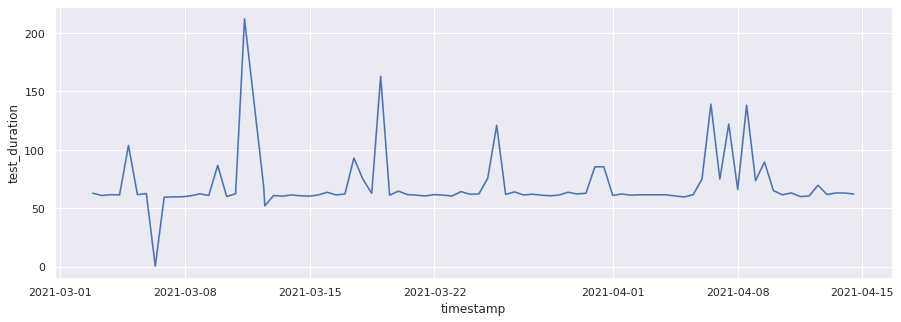

In [14]:
subdf = df[["timestamp", "test_duration"]]
sns.lineplot(data=subdf, x="timestamp", y="test_duration")

## Visualize Selected KPIs

In [49]:
print("Available KPI files to choose from:", end="\n\n")
for k in kpis_in_kpifile.keys():
    print(k)

Available KPI files to choose from:

avg_correlation
blocked_timed_out
build_pass_failure
correlation
number_of_flakes
pct_fixed_each_ts
persistent_failures
test_pass_failures
time_to_test


In [50]:
selected_filename = "number_of_flakes"

In [51]:
print(f'Available dates to choose from for the file "{selected_filename}":', end="\n\n")
for d in dates_available_for_kpifile[selected_filename]:
    print(d)

Available dates to choose from for the file "number_of_flakes":

2021-4-14
2021-4-16
2021-4-19
2021-4-27
2021-4-29
2021-5-3
2021-5-4
2021-5-5
2021-5-6


In [52]:
selected_date = "2021-4-14"

In [53]:
print(f'Available KPIs to choose from for the file "{selected_filename}":', end="\n\n")
for m in kpis_in_kpifile[selected_filename]:
    print(m)

Available KPIs to choose from for the file "number_of_flakes":

test_duration
flake


In [54]:
selected_kpis = [
    "test_duration",
    "flake",
]

In [55]:
# read one of the kpis to plot the selected metrics objects from ceph
metric_df = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False


### For different Jobs under a given Dashboard

In this section, we'll compare jobs within a dashboard on the basis of the selected KPIs. That is, given a dashboard (e.g. `"redhat-openshift-ocp-release-4.6-informing"`), we will plot the KPI values corresponding to the `Overall` row for each job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-aws`, `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`, etc.) under that dashboard. This would help us determine if our efforts should be focused on a particular platform or install config for OpenShift.

In [12]:
tabs = metric_df["tab"].unique()
print("Available dashboard tabs to choose from:", end="\n\n")
for t in tabs:
    print(t)

Available dashboard tabs to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-re

In [13]:
# Select the dashboard and test
selected_tab = '"redhat-assisted-installer"'
selected_test = "Overall"

In [16]:
def plot_grids(tab, test, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, test name, metric df, the KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different jobs(grids)
    in a given TestGrid dashboard tab
    """
    for grid in df[df["tab"] == tab]["grid"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(
            x="timestamp",
            y=metric_name,
            data=grid_values,
            legend="brief",
            label=str(grid),
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

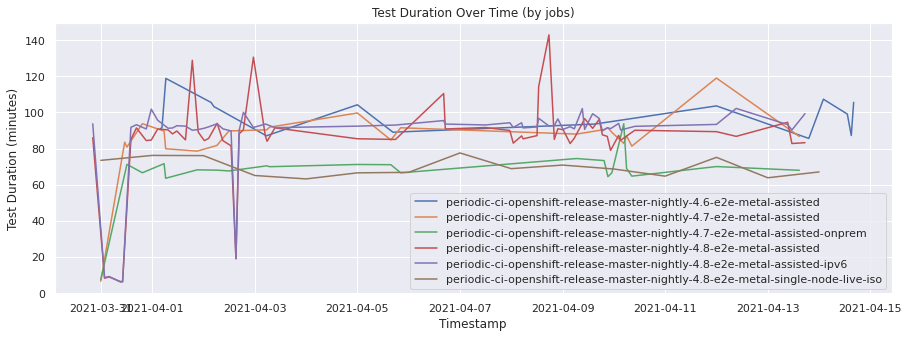

In [17]:
# Here we are plotting the test duration metric over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by jobs)",
)

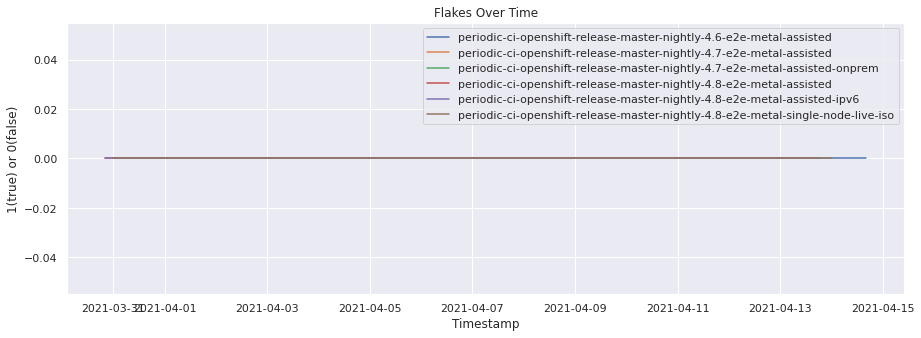

In [18]:
# Here we are plotting the flakes over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "1(true) or 0(false)",
    "Flakes Over Time",
)

### For different Tests under a given Job

In this section, we'll compare the various tests that are run in a job, on the basis of the selected KPIs. That is, given a job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`), we will plot the KPI values corresponding to each test (e.g. `operator conditions cluster-autoscaler`, `operator conditions cloud-credential`, etc.) under that job. This would help us determine if our efforts should be focused on a particular set of components in OpenShift.

In [19]:
# For a given dashboard, identify all the jobs (grids)
selected_tab = '"redhat-openshift-ocp-release-4.1-informing"'

grids = metric_df[metric_df["tab"] == selected_tab]["grid"].unique()
print("Available grids to choose from:", end="\n\n")
for g in grids:
    print(g)

Available grids to choose from:

release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.1-nightly
release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1


In [20]:
# Select the job(grid)
selected_grid = "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1"

In [21]:
df = metric_df.copy()
df = df[(df["tab"] == selected_tab) & (df["grid"] == selected_grid)]
df.head()

,timestamp,tab,grid,test,test_duration,flake
2163889,2021-04-14 00:41:26,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,255.066667,False
2163890,2021-04-13 00:39:54,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,68.900000,False
2163891,2021-04-12 00:38:35,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,61.916667,False
2163892,2021-04-11 00:37:08,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,67.800000,False
2163893,2021-04-10 00:36:09,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,85.800000,False


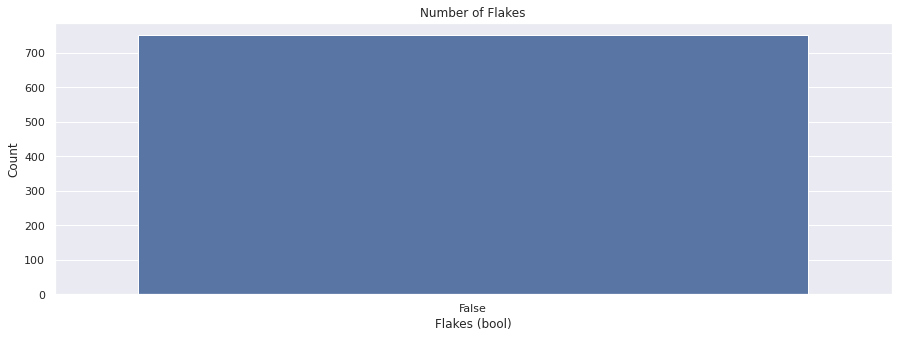

In [22]:
## Count of flakes identified in the tests for a particular grid(job) in a given TestGrid dashboard tab
sns.countplot(x="flake", data=df)
plt.xlabel("Flakes (bool)")
plt.ylabel("Count")
plt.title("Number of Flakes")
plt.show()

In [23]:
def plot_tests(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, grid(job), metric data frame, KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different tests in a job(grid) of a given
    TestGrid dashboard tab
    """
    for test in df[(df["tab"] == tab) & (df["grid"] == grid)]["test"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(x="timestamp", y=metric_name, data=grid_values, legend="brief")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

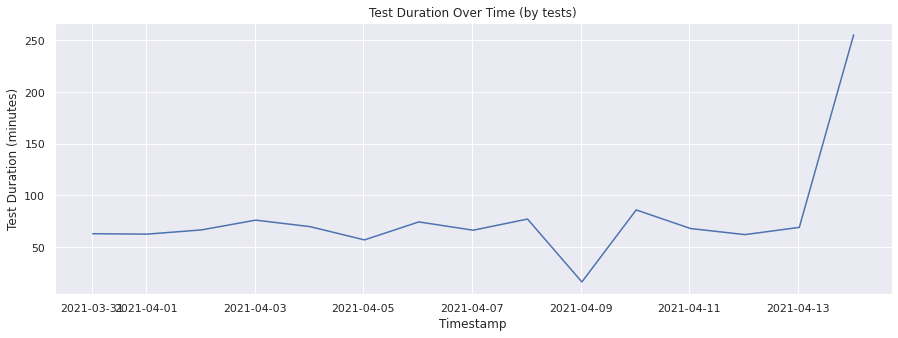

In [24]:
# Here we are plotting the test duration metric over time for different tests within a given dashboard tab
plot_tests(
    selected_tab,
    selected_grid,
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by tests)",
)

**NOTE** The values for "test_duration" are only available for "Overall" hence the above graph shows only one lineplot.

## Variation of KPI metrics over time

We can plot the KPI metric values over time to identify any change, pattern or trend in the values for different grids(jobs) and different tests

In [26]:
def plot_metrics_tab_grid(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the TestGrid dashboard tab, grid(job), metric data frame, the KPI metric name,
    and the title of the graph

    Plots the KPI values over time for the particular grid(job) in a given TestGrid dashboard tab
    Plots change in KPI metrics over time
    """
    df = df[(df["tab"] == tab) & (df["grid"] == grid)]
    print(df.shape)
    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

(1275, 6)


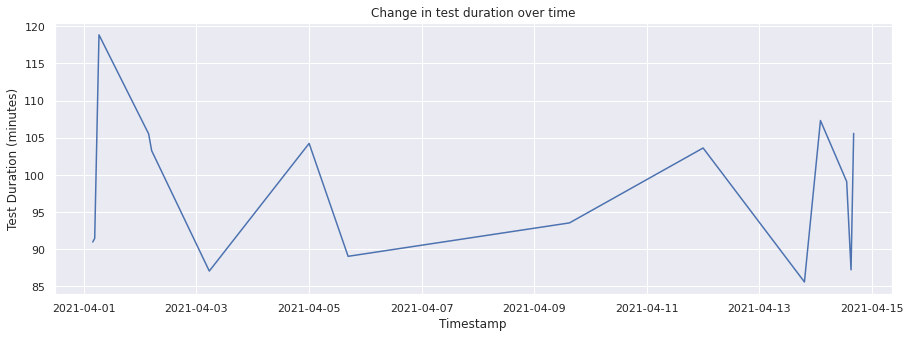

In [27]:
# Select the dashboard tab, grid(job) and the KPI metric you wish to plot the graphs for
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Change in test duration over time",
)

(1748, 6)


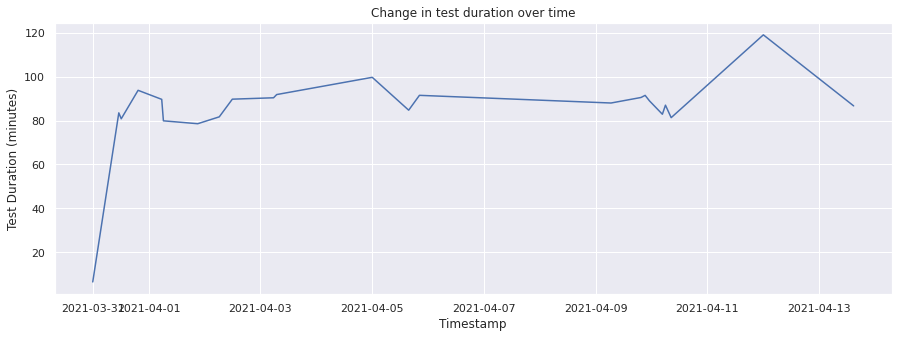

In [28]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Change in test duration over time",
)

(4560, 6)


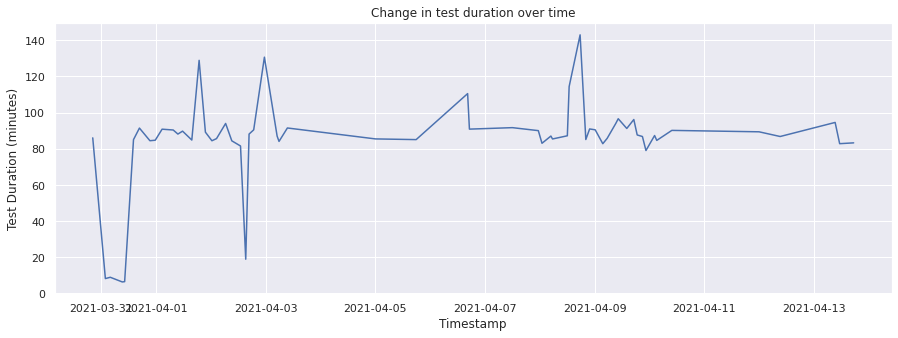

In [29]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Change in test duration over time",
)

(1275, 6)


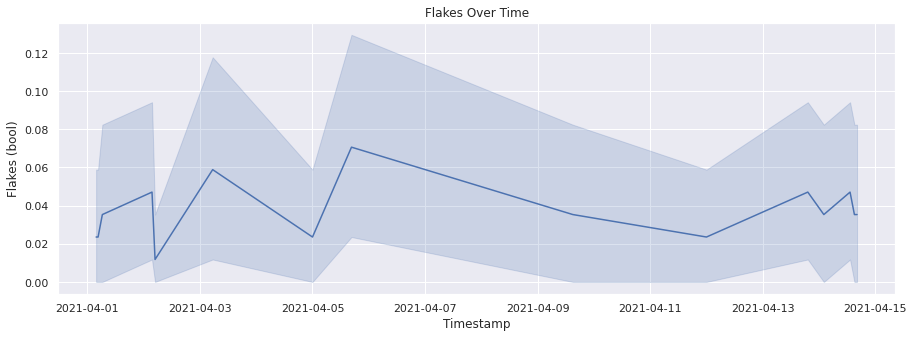

In [30]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "Flakes (bool)",
    "Flakes Over Time",
)

(1748, 6)


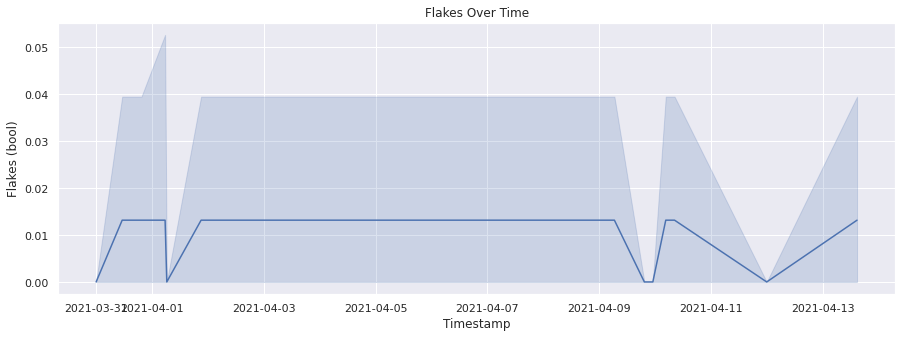

In [31]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "Flakes (bool)",
    "Flakes Over Time",
)

(4560, 6)


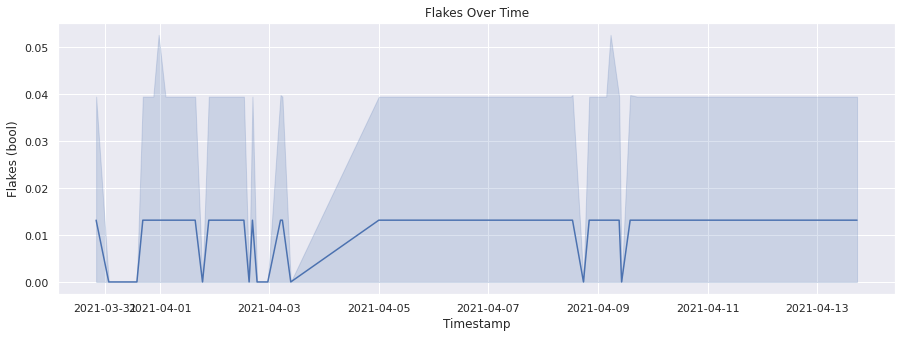

In [32]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "Flakes (bool)",
    "Flakes Over Time",
)

## Conclusion :
In this notebook, we have tried to read the collected metrics from ceph and use visualization libraries like `seaborn` to explore our data. We have tried two different granularities here :
* job level : Here we choose a dashboard and analyze across various jobs for "Overall" test.
* test level : Here we choose a dashboard and job and then visualize the metrics for various tests.

For future work, we could look into other collected metrics and explore more visualization tools for further detailed analyses. 